In [1]:
from models_mae import mae_vit_base_patch16

d:\transformers-pytorch\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = mae_vit_base_patch16()

In [59]:
import torch

example_input = torch.randn((1, 3, 256, 256))

patch_size = 16
assert example_input.shape[2] % patch_size == 0 and example_input.shape[3] % patch_size == 0

example_input = torch.nn.functional.interpolate(example_input, scale_factor=1/patch_size)
output = model(example_input)

In [4]:
example_input.shape

torch.Size([1, 3, 16, 16])

In [7]:
from pathlib import PureWindowsPath

folder_path = PureWindowsPath(r'pretrained.pth')
folder_path.as_posix()

'pretrained.pth'

In [8]:
model

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=768, out_features=512, b

In [5]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [61]:
cp_dict = torch.load('finetuned.pth', map_location=torch.device('cpu'))

: 

In [ ]:
cp_dict['model'] = cp_dict['model']
state_dict = model.state_dict()

model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [8]:
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import models_mae
import librosa
import librosa.display

In [38]:
MELBINS=256
TARGET_LEN=256
def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, 
                        window_type='hanning', num_mel_bins=MELBINS, dither=0.0, frame_shift=10)
    # AudioSet: 1024 (16K sr)
    # ESC: 512 (8K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank

In [39]:
def display_fbank(bank, minmin=None, maxmax=None):
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')

In [40]:
# !pip install librosa

In [41]:
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("../")
import models_mae
import librosa
import librosa.display

In [42]:
torchaudio.load('disconnect_11.wav')

(tensor([[ 0.3117,  0.6472,  0.8109,  ..., -0.0111, -0.0038,  0.0009]]), 11025)

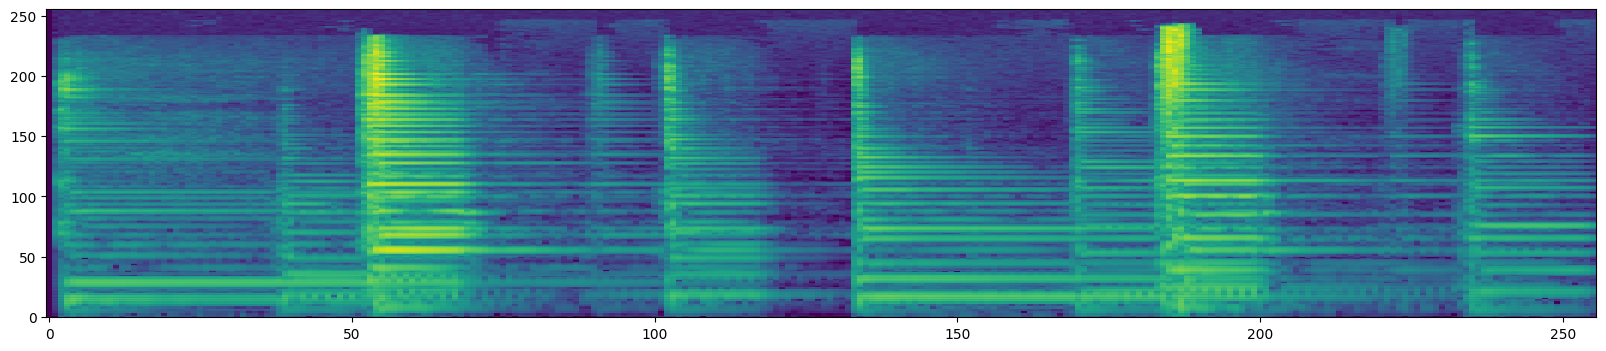

In [43]:
wav_file = r'acoustic-guitar-loop-f-91bpm-132687.wav'
#wav_file = '/large_experiments/cmd/audioset/balance_wav/1JmYeNQ1jEI.wav'
fbank = wav2fbank(wav_file)
fbank = norm_fbank(fbank)
display_fbank(fbank)

In [44]:
import torch

In [45]:
x = torch.tensor(fbank)
print(x.shape)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = x.unsqueeze(dim=0)
print(x.shape)
#x = torch.einsum('nhwc->nchw', x)
x = x.repeat(1, 3, 1, 1)
print(x.shape)

torch.Size([256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])


C:\Users\acer\AppData\Local\Temp\ipykernel_31480\424159883.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


In [46]:
example_input = torch.nn.functional.interpolate(x, scale_factor=1/16)

In [21]:
import torch
import sys
sys.path.append("AudioMAE-pytorch/")
from audio_mae import AudioMaskedAutoencoderViT
from torch import nn

from functools import partial

audio_mels = torch.ones([2, 1, 1024, 128])

# Paper recommended archs
model_x  = AudioMaskedAutoencoderViT(
        num_mels=128, mel_len=1024, in_chans=1,
        patch_size=16, embed_dim=768, encoder_depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=16, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
        
loss, pred, mask = model_x(audio_mels)

sys.path.append("../")

768 (64, 8)
here1: (513, 768)
here1: (512, 512)
torch.Size([1, 513, 768])
torch.Size([2, 512, 768])


In [22]:
x.shape

torch.Size([1, 3, 1024, 128])

In [23]:
model_x(x)

RuntimeError: Given groups=1, weight of size [768, 1, 16, 16], expected input[1, 3, 1024, 128] to have 1 channels, but got 3 channels instead

In [17]:
model(example_input)

(tensor(1.3403, grad_fn=<DivBackward0>),
 tensor([[[ 1.4765,  0.4773,  0.8606,  ...,  0.9207, -0.4783,  0.1677],
          [ 1.4592,  0.5146,  0.7905,  ...,  0.8800, -0.4328,  0.0193],
          [ 1.4458,  0.5540,  0.6250,  ...,  0.8793, -0.4587, -0.1683],
          ...,
          [ 1.8260,  0.2209,  0.1395,  ...,  1.2986,  0.0458, -0.7987],
          [ 1.6781,  0.8804, -0.2371,  ...,  1.4190, -0.2535, -0.3048],
          [ 1.7020,  1.0180, -0.2036,  ...,  1.3773, -0.1748, -0.3240]]],
        grad_fn=<SliceBackward0>),
 tensor([[1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
          1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
          1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
          1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
          1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0.,

In [ ]:
torch.rand((1, 197, 768)).shape

torch.Size([1, 197, 768])

In [ ]:
torch.rand((1, 197, 768))[:, 1:, :].shape

torch.Size([1, 196, 768])

In [ ]:
# example_input = torch.nn.functional.interpolate(x, scale_factor=1/patch_size)

o = model(x)

torch.Size([1, 197, 768])
torch.Size([1, 512, 768])


RuntimeError: The size of tensor a (512) must match the size of tensor b (196) at non-singleton dimension 1

In [ ]:
# Assuming MELBINS=128 and TARGET_LEN=1024
MELBINS = 128
TARGET_LEN = 1024

# Your existing code for wav2fbank and norm_fbank functions...

wav_file = r'acoustic-guitar-loop-f-91bpm-132687.wav'
fbank = wav2fbank(wav_file)
fbank = norm_fbank(fbank)

# Reshape the tensor to match the model's input shape
x = torch.tensor(fbank)

# Ensure the sequence length matches TARGET_LEN
if x.shape[0] < TARGET_LEN:
    # Pad if the sequence is shorter than TARGET_LEN
    pad_size = TARGET_LEN - x.shape[0]
    x = torch.nn.functional.pad(x, (0, 0, 0, pad_size))
elif x.shape[0] > TARGET_LEN:
    # Truncate if the sequence is longer than TARGET_LEN
    x = x[:TARGET_LEN, :]

# Add batch and channel dimensions
x = x.unsqueeze(dim=0).unsqueeze(dim=0)

# Repeat the single channel to match the model's expected number of channels (3)
x = x.repeat(1, 3, 1, 1)

print(x.shape)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
torch.Size([1, 3, 1024, 128])


C:\Users\acer\AppData\Local\Temp\ipykernel_11720\2519713112.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


In [ ]:
model(x)

RuntimeError: The size of tensor a (512) must match the size of tensor b (196) at non-singleton dimension 1

In [ ]:
x.shape

torch.Size([1, 3, 1024, 128])

In [ ]:
model(x)

RuntimeError: The size of tensor a (512) must match the size of tensor b (196) at non-singleton dimension 1

In [ ]:
patch_size = 16
assert x.shape[2] % patch_size == 0 and x.shape[3] % patch_size == 0

# Resize the input to make sure it's divisible by the patch size
# x = torch.nn.functional.interpolate(x, scale_factor=1/patch_size)

In [ ]:
x.shape

torch.Size([1, 3, 64, 8])

In [ ]:
# run MAE
loss, y, mask,_ = model(x.float(), mask_ratio=0.1)
print('y_shape:',y.shape, mask.shape)
y = model.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()

RuntimeError: Calculated padded input size per channel: (64 x 8). Kernel size: (16 x 16). Kernel size can't be greater than actual input size

In [ ]:
model

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=768, out_features=512, b